In [2]:
from neo4j import GraphDatabase, RoutingControl
from dotenv import load_dotenv
import os
import logging


log = logging.getLogger(__name__)

load_dotenv()
api_uri = os.getenv("NEO4J_URI")
api_usr = os.getenv("NEO4J_USR")
api_secret = os.getenv("NEO4J_PW")

driver = GraphDatabase.driver(api_uri, auth=(api_usr, api_secret))

In [5]:

round = 1
with driver.session():
    records, _, _ = driver.execute_query("""
                    WITH $this_round as this_round
                    MATCH (u:User)-[f:SCRAPED_ON]->(r:Round WHERE r.id < this_round)
                    RETURN u.uri as uri
                    ORDER  BY r  LIMIT 100
                    UNION ALL
                    MATCH (u:User) WHERE NOT (u)-[]->(:Round)
                    RETURN u.uri as uri
                    LIMIT 100""",
                            this_round=round, database="neo4j", routing_=RoutingControl.READ)
    print(records)

[<Record uri='https://mastodon.social/users/sotoarmengol'>, <Record uri='https://mastodon.social/users/maximclatellot'>, <Record uri='https://mastodon.social/users/Gargron'>, <Record uri='https://mastodon.social/users/siracusa'>, <Record uri='https://mastodon.social/users/tonimelero'>, <Record uri='https://mastodon.social/users/citiobs'>, <Record uri='https://mastodon.social/users/samantavillar'>, <Record uri='https://mastodon.social/users/ardaelovich'>, <Record uri='https://mastodon.social/users/m_doncel'>, <Record uri='https://mastodon.social/users/rosbyt'>, <Record uri='https://mastodon.social/users/jsalvia'>, <Record uri='https://mastodon.social/users/jose_plus_one'>, <Record uri='https://mastodon.social/users/Sylviatic'>, <Record uri='https://mastodon.social/users/rlm13'>, <Record uri='https://mastodon.social/users/selmins'>, <Record uri='https://mastodon.social/users/gorbag'>, <Record uri='https://mastodon.social/users/coloco'>, <Record uri='https://mastodon.social/users/astorza'

In [8]:
round = 1
with driver.session():
    records, _, _ = driver.execute_query("""
                    WITH $this_round as this_round
                    MATCH (u:User)-[f:SCRAPED_ON]->(r:Round {id:this_round})
                    MATCH (u) -[]->(v:User)
                    RETURN v.uri as uri, count(u) AS count 
                    ORDER BY count(u) DESC 
                    LIMIT 10""",
                            this_round=round, database="neo4j", routing_=RoutingControl.READ)
    print(records)

TransientError: {code: Neo.TransientError.General.MemoryPoolOutOfMemoryError} {message: The allocation of an extra 2.0 MiB would use more than the limit 16.0 MiB. Currently using 15.0 MiB. db.memory.transaction.total.max threshold reached}

In [14]:

def query_db(query):
    with driver.session():
        records, _, _ = driver.execute_query(query ,
                                                  usr=api_usr,
                                                  database="neo4j",
                                                  routing_=RoutingControl.READ)
        return records

# records = query_db("""MATCH (v:User) -[]->(s:Server)
#                                                     RETURN s.url as server, count(v) AS count 
#                                                     ORDER BY count(v) DESC 
#                                                     LIMIT 10""")

# {record['server']:record['count'] for record in records}

    

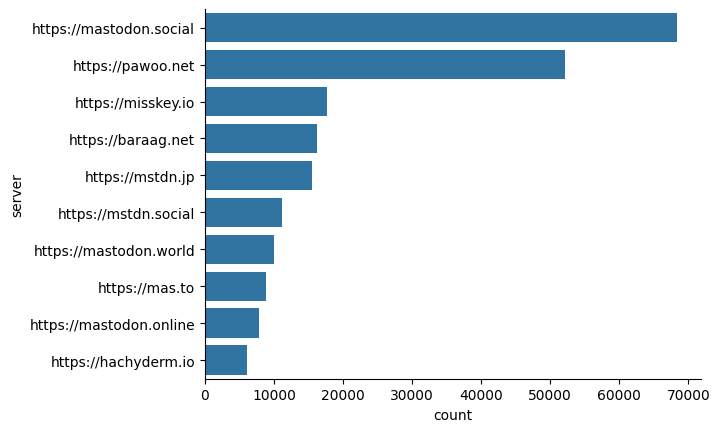

In [89]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame([(record['server'],record['count']) for record in records])
df.columns = ['server', 'count']

sns.barplot(data=df, y= 'server', x='count')
sns.despine()

In [12]:
unreachable = query_db("""match (u:User)-[:SCRAPED_ON {usr_status:'NOT REACHABLE'}]->() return count(u) as count
""")

finished = query_db("""match (u:User)-[:SCRAPED_ON]->(:Round {id:1}) return count(u) as count
""")
seen = query_db("""match (u:User) return count(u) as count
""")

print("""
Total user nodes: {:,}
Nones scraped so far on round 1: {:,} ({:.2f}%)
Nodes marked as unreachable:{:,} ({:.2f}%)
""".format(seen[0]['count'],
           finished[0]['count'] - unreachable[0]['count'],
           100*(finished[0]['count'] - unreachable[0]['count'])/seen[0]['count'],
           unreachable[0]['count'],
           100*unreachable[0]['count']/seen[0]['count'])
     )


Total user nodes: 4,480,729
Nones scraped so far on round 1: 526,604 (11.75%)
Nodes marked as unreachable:42,603 (0.95%)



In [30]:
records = query_db("""CALL gds.graph.project(
                                                          'myGraph',
                                                          'User',
                                                          {
                                                            FOLLOWS: {
                                                              orientation: 'REVERSE'
                                                            }
                                                          }
                                                        )""")

print(records)

[<Record nodeProjection={'User': {'label': 'User', 'properties': {}}} relationshipProjection={'FOLLOWS': {'aggregation': 'DEFAULT', 'orientation': 'REVERSE', 'indexInverse': False, 'properties': {}, 'type': 'FOLLOWS'}} graphName='myGraph' nodeCount=4773558 relationshipCount=78585720 projectMillis=16076>]


In [33]:
records = query_db("""
CALL gds.graph.export.csv('myGraph',  { exportName: 'my-export.csv',
                                        additionalNodeProperties: [{ uri: {defaultValue: 'nouri'}}]

})
""")

print(records)

[<Record exportName='my-export.csv' graphName='myGraph' nodeCount=4773558 relationshipCount=78585720 relationshipTypeCount=1 nodePropertyCount=4773558 relationshipPropertyCount=0 writeMillis=17511>]


In [34]:
records = query_db("""CALL gds.graph.drop('myGraph', false)""")

print(records)

[<Record graphName='myGraph' database='neo4j' memoryUsage='' sizeInBytes=-1 nodeCount=4773558 relationshipCount=78585720 configuration={'relationshipProjection': {'FOLLOWS': {'aggregation': 'DEFAULT', 'orientation': 'REVERSE', 'indexInverse': False, 'properties': {}, 'type': 'FOLLOWS'}}, 'readConcurrency': 4, 'relationshipProperties': {}, 'nodeProperties': {}, 'jobId': '343d2f19-9263-4174-9134-b7478771c8de', 'nodeProjection': {'User': {'label': 'User', 'properties': {}}}, 'logProgress': True, 'creationTime': neo4j.time.DateTime(2024, 1, 8, 18, 10, 55, 813899406, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>), 'validateRelationships': False, 'sudo': False} density=3.4487309935993556e-06 creationTime=neo4j.time.DateTime(2024, 1, 8, 18, 10, 55, 813899406, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>) modificationTime=neo4j.time.DateTime(2024, 1, 8, 18, 11, 11, 918134746, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>) schema={'graphProperties': {}, 'nodes': {'User': {}}, 'r

In [10]:
from graphdatascience import GraphDataScience



gds = GraphDataScience(api_uri, auth=(api_usr, api_secret))




In [11]:
G, metadata = gds.graph.project(
    "my-graph", 
    "User",
    {"FOLLOWS" : {'orientation': "REVERSE"}}
)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'my-graph' already exists.}

In [17]:
G = gds.graph.get('my-graph')
gds.degree.mutate(G, mutateProperty='degree')

nodePropertiesWritten                                               4775215
centralityDistribution    {'min': 0.0, 'max': 419739.9999923706, 'p90': ...
mutateMillis                                                              3
postProcessingMillis                                                    189
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object

In [31]:
gds.graph.drop(gds.graph.get('my-su-graph'))
sG = gds.beta.graph.project.subgraph('my-su-graph', G, 'n.degree > 100.0', "*")

In [32]:
sG

GraphCreateResult(graph=Graph({'graphName': 'my-su-graph', 'nodeCount': 109912, 'relationshipCount': 21361792, 'database': 'neo4j', 'configuration': {'relationshipProperties': {}, 'jobId': '75ad9c35-3ec8-4d16-848b-8bf05478bd82', 'validateRelationships': False, 'nodeFilter': 'n.degree > 100.0', 'sudo': False, 'relationshipProjection': {'FOLLOWS': {'aggregation': 'DEFAULT', 'orientation': 'REVERSE', 'indexInverse': False, 'properties': {}, 'type': 'FOLLOWS'}}, 'readConcurrency': 4, 'nodeProperties': {}, 'nodeProjection': {'User': {'label': 'User', 'properties': {}}}, 'logProgress': True, 'concurrency': 4, 'creationTime': neo4j.time.DateTime(2024, 1, 9, 15, 47, 55, 159264462, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>), 'relationshipFilter': '*', 'parameters': {}}, 'schema': {'graphProperties': {}, 'nodes': {'User': {'degree': 'Float (DefaultValue(NaN), TRANSIENT)'}}, 'relationships': {'FOLLOWS': {}, 'SIMILAR': {'score': 'Float (DefaultValue(NaN), TRANSIENT, Aggregation.NONE)'}}},

In [37]:
gds.nodeSimilarity.mutate(gds.graph.get('my-su-graph'),
                          degreeCutoff= 100, topK= 10,
                                   mutateRelationshipType='sim',
                                   mutateProperty='score')

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                       0
computeMillis                                                       1755022
mutateMillis                                                            192
postProcessingMillis                                                     -1
nodesCompared                                                         57052
relationshipsWritten                                                 570520
similarityDistribution    {'min': 0.013824880123138428, 'p5': 0.04972380...
configuration             {'mutateProperty': 'score', 'jobId': 'f237a571...
Name: 0, dtype: object

In [39]:
gds.graph.get('my-su-graph').relationship_properties()

similarity    [score]
sim           [score]
FOLLOWS            []
SIMILAR       [score]
dtype: object

In [42]:
gds.graph.writeRelationship(gds.graph.get('my-su-graph'),'sim',
  'score')

writeMillis                       0
graphName               my-su-graph
relationshipType                sim
relationshipProperty          score
relationshipsWritten         570520
propertiesWritten            570520
Name: 0, dtype: object